In [1]:
# required imports

from pymodbus.client.sync import ModbusSerialClient as mbc
from datetime import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
#required imports for DAQ-->
import nidaqmx
from nidaqmx.stream_readers import AnalogMultiChannelReader
from nidaqmx import constants
from nidaqmx.constants import (TerminalConfiguration)
#Required imports for Motor Com -->
import serial as ser
#======
from scipy import stats
import csv
import time as ti
from matplotlib.axes import Axes as ax
%matplotlib notebook

# API for Motor Coms and DAQ Coms 

In [2]:
#------------------------Motor API for Grbl Bard via USB serial commands-------------------#
#------------------------------------------------------------------------------------------#
# $0=10
# $1=0
# $2=0
# $3=1
# $4=1
# $5=0
# $6=0
# $10=1
# $11=0.010
# $12=0.002
# $13=0
# $20=0
# $21=1
# $22=1
# $23=3
# $24=25.000
# $25=1000.000
# $26=250
# $27=5.000
# $30=1000
# $31=0
# $32=0
# $100=26.667
# $101=26.667
# $102=250.000
# $110=100000.000
# $111=100000.000
# $112=500.000
# $120=300.000
# $121=300.000
# $122=10.000
# $130=1500.000
# $131=1500.000
# $132=1500.000
class Motor:
    #function initializes grbl
    def __init__(self,address):
        try:
            #creat variable with communication line to motor
            #.Serial(port_address,board_rate) -----> baud rate is 115200 for Grbl firmware 1.1
            self.rob = ser.Serial(str(address),115200)
            #send command that tells grbl we are starting a serial communication line
            self.rob.write('\r\n\r\n'.encode('utf'))
            ti.sleep(2)   # Wait for grbl to initialize
            #read back grbl response
            back_com = self.rob.read_all().decode('utf-8')
            #print response
            print(back_com)
            #check if response is correct
            if(back_com[:6] != ''):
                print('')
            else:
                print('WARNING : Grbl board did not communicate back properly')
        #print exception is connection does not work
        except Exception as e:
            print(e)
            print('Failed to connect to motor driver board')
    #function will close Grbl
    def close(self):
        try:
            self.rob.close()
        except Exception as e:
            print(e)
            print('Serial communication line failed to close')
    #function will move bar to the position specifies in mm from home position
    #They will not 
    def move_pos(self,position1):
        try:
            #creat grbl command with specified coardinate
            com = 'G0 X' + str(position1) +' Y' + str(position1) +'\r\n'
            print(com)
            #write command to grbl board
            self.rob.write(com.encode('utf'))
            #time.sleep(2)   # Wait for grbl to initialize
            #read back grbl response
            #back_com = self.rob.read_all().decode('utf-8')
            #print(back_com)
        except Exception as e:
            print(e)
            print('Motor failed to move to given position.')
            user = input('Try again?:Y/N')
            if((str(user) == 'Y') | (str(user) == 'y')):
                try:
                    self.rob.write(com.encode('utf'))
                    ti.sleep(2)   # Wait for grbl to initialize
                    #read back grbl response
                    back_com = self.rob.read_all().decode('utf-8')
                    print(back_com)
                except Exception as e:
                    print(e)
                    print('Motor failed to move to given position.')
            else:
                print('possible solutions: home the device with home(), power cycle device')
            
    #function homes the light sensor bar
    def home(self):
        try:
            # HOME
            self.rob.write('$h\r\n'.encode('utf'))  # Tell grbl to home
            ti.sleep(1)   # Wait for grbl
#             self.rob.write('g92 x0 y0 z0\r\n'.encode('utf-8')) # reset g coordinates to 0
#             back_com = self.rob.read_all().decode('utf-8')
            print(back_com)
        except Exception as e:
            print(e)
            print('failed to home device. Homing possibly turned off. $21 and $22 must == 1')
    #function writes to grbl a serial command. Usefull for trouble shooting and settup
    def write(self,to_write):
        try:
            com = str(to_write) + '\r\n'
            self.rob.write(com.encode('utf'))  # Tell grbl to home
            #time.sleep()   # Wait for grbl
            print(self.rob.read_all().decode('utf-8'))
        except Exception as e:
            print(e)
            print('command send failed. Ensure command is either acceptable G code and machine is turned')
    #flush input
    def flushInput(self):
        try:
            self.rob.flushInput()
        except Exception as e:
            print(e)
    #read untill
    def read_until(self,temp):
        try: 
            temp = self.rob.read_until().decode('utf-8')
            return temp
        except Exception as e:
            print(e)
#------------------------DAQ API for NI DAQ 9205 via USB DAQmx python library-------------------#
#required imports-->
# import nidaqmx
# from nidaqmx.stream_readers import AnalogMultiChannelReader
# from nidaqmx import constants
# from nidaqmx.constants import (TerminalConfiguration)
# import pandas as pd
#----------------------------------------------------------------------------------------------#

class DAQ:
#---------initial set up for DAQ----------------#
     def __init__(self):
        try:
            self.task = nidaqmx.Task()
        except Exception as e:
            print(e)
            print('Failed to connect to NI DAQ.')
#--------------start task-----------------------#
     def start(self):
        try: 
            self.task.start()
        except Exception as e:
            print(e)
            print('Task failed to start correctly. Ensure task has already been set up.')
#--------------stop task-------------------------#
     def stop(self):
        try: 
            self.task.stop()
        except Exception as e:
            print(e)
            print('Task failed to stop correctly. Ensure task has already been started.')
#----------set up tasking------------------------#
#wireing for differential mode goes posotive to terminal specified negative to terminal acrross 
# name = name of channel see https://www.apexwaves.com/pdf/manuals/NI-9205/NI-9205-Getting-Started-Guide.pdf page 14 for options
# mode is autimaticly set to differntial to change see https://nidaqmx-python.readthedocs.io/en/latest/constants.html section TerminalConfig
     def creat_single_volt_RSE_task(self,name):
        try:
            self.task.ai_channels.add_ai_voltage_chan(name, terminal_config = TerminalConfiguration.RSE, min_val=0, max_val=5)
            self.task.timing.cfg_samp_clk_timing(10000)
        except Exception as e:
            print(e)
            print('Failed to creat task. Check port and device name is correct')
#----------set up tasking------------------------#    
# name = name of channel see https://www.apexwaves.com/pdf/manuals/NI-9205/NI-9205-Getting-Started-Guide.pdf page 14 for options
#name must follow this template "cDAQ1Mod1/ai1:3" "DAQname+modualname/portname_start:portname_end"
     def creat_multi_volt_RSE_task(self,name):
        try:
            self.task.ai_channels.add_ai_voltage_chan(name, terminal_config = TerminalConfiguration.RSE, min_val=0, max_val=5)
            #timing figured out from this link - https://knowledge.ni.com/KnowledgeArticleDetails?id=kA00Z0000019ZWxSAM&l=en-US
            self.task.timing.cfg_samp_clk_timing(10000)
        except Excpetion as e:
            print(e)
            print('Failed to creat task. Check port and device name is correct') 
#--------collect data-------------------------------#
     def collect_all_data(self,read):
        try:
            #collect 10 data points for each and average
            pool = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
            for k in range(100):
                newData = self.task.read()
                for m in range(16):
                    pool[m] += newData[m]
                #need to creat dict with all values and corrosponding names
                #in read
            for i in range(16):
                
                read['PD' + str(i+1)] =float(pool[i]/100)
            return read
        except Exception as e:
            print(e)
            print('Failed to collect and store data')

     def collect_data(self,data):
        for i in range(10):
            num = 0
            for k in range(100):
                newData = self.task.read()
                num += newData
            read = {'Volts':num/100}
            data = data.append(read, ignore_index=True)
        
        return data

# Putting the peices together...
## Here I will finaly take the data from the photo detectors and move the motor at the same time
### Notes....
1. Must make sure motor is off during data aquisition (ie. no powor to the motor) this is to limit noise on the photo detector line
2. Motor must move in 26 inch incraments
3. Motor must not move past 1500 mm (This will slam motor into assembly
4. Data will be taken from each photo detector 1000 times at each position (16,000) mesurments per stop. Timing for DAQ task will initialy be set to 10,000 samples per chanel. This may get changed

Running test will return a pandas data frame with the following attributes
columns=['Time','Position','PD1','PD2','PD3','PD4','PD5','PD6','PD7','PD8','PD9','PD10','PD11','PD12','PD13','PD14','PD15','PD16']
rows = 56

In [3]:
# These are all the functions I have built to work with the LED Robot Tester

#This function will run the test and spit out a 2D data frame with all the values 
def Test():
    daq = DAQ()
    daq.creat_multi_volt_RSE_task("cDAQ1Mod1/ai1:16")
    rob = Motor('COM3')
    rob.home()
    #set up data to make Pandas data frame with
    data = [[dt.now(),0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]]
    read = dict()
    #creat data frame to store data
    df = pd.DataFrame(data, columns=['Time','Position','PD1','PD2','PD3','PD4','PD5','PD6','PD7','PD8','PD9','PD10','PD11','PD12','PD13','PD14','PD15','PD16'])
    #start up daq aquisition can keep running this till very end of test. Will record data when necesarry
    x=0
    broke = 1
    #this will be the length of your scanning area devided by 26 ( make sure you dont smash it into the end !!!)
    length_o_rig = 55
    while (x != length_o_rig) & (broke == 1):
        #move 26 mm after ever loop
        pos = 26*(x+1)
        rob.move_pos(pos)
        #--------------Here you spam it with '?' and just keep reading and wait till it sees the idle then stop spamming
        #when you see correct position you know it has stopped moving 
        # the key is to read_until and flush_input both these somehow make it respond back super duper quick
        # this gives mm level precision to location
        tf = 1
        while tf==1 & broke == 1:
            rob.flushInput()
            #must sleep for .1 seconds here so we dont read the same number more than once. This leads to skiping
            ti.sleep(.1)
            rob.write('?')
            temp = ''
            #this collects the response back
            temp = rob.read_until(temp)
            # splits <Run|MPos:2.065,0.000,0.000|FS:2640,0|Pn:YZ>\r\n at , then . to get y position
            split1 = temp.split(',')[1]
            pos_check = split1.split('.')[0]
            print(pos_check)
            #this number is the position the software understands the motor to be at
            start = 1495
            #I check if the position I sent it to is where it is currently 
            #this is where data collection happens
            if ((int(pos_check)-1) <= int((-start + pos))) & ((int(pos_check)+1) >= int((-start + pos))):
                #collect current time and put it in data frame
                ti.sleep(.1)
                daq.start()
                #function in API built above see for code mechanism
                read = daq.collect_all_data(read)
                ti.sleep(.1)
                daq.stop()
                read['Time'] = dt.now()
                read['Position'] = pos
                df = df.append(read, ignore_index=True)
                tf=0
        x+=1
   # drop the first row of df which is garbage
    df.drop(0,axis=0,inplace = True)
    #step it back to home position 
    rob.move_pos(500)
    ti.sleep(3)
    rob.move_pos(0)
    #cannot close down communication untill device is done moving
    ti.sleep(10)
    #close devices
    rob.close()
    # function spits out df
    return df




#this functions runs the test 10 times and collects them all in ray[] a list
#this is usefull when trying to check reproducibility over time
def Collect_10_runs():
    daq = DAQ()
    daq.creat_multi_volt_RSE_task("cDAQ1Mod1/ai1:16")
    rob = Motor('COM3')
    rob.home()   
    ray = []    
    for i in range(10):
        #set up data to make Pandas data frame with
        data = [[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]]
        read = dict()
        #creat data frame to store data
        df = pd.DataFrame(data, columns=['PD1','PD2','PD3','PD4','PD5','PD6','PD7','PD8','PD9','PD10','PD11','PD12','PD13','PD14','PD15','PD16'])
        #start up daq aquisition can keep running this till very end of test. Will record data when necesarry
        x=0
        broke = 1
        #this will be the length of your scanning area devided by 26 ( make sure you dont smash it into the end !!!)
        length_o_rig = 55
        while (x != length_o_rig) & (broke == 1):
            #move 26 mm after ever loop
            pos = 26*(x+1)
            rob.move_pos(pos)
            #--------------Here you spam it with '?' and just keep reading and wait till it sees the idle then stop spamming
            #when you see correct position you know it has stopped moving 
            # the key is to read_until and flush_input both these somehow make it respond back super duper quick
            # this gives mm level precision to location
            tf = 1
            while tf==1 & broke == 1:
                rob.flushInput()
                #must sleep for .1 seconds here so we dont read the same number more than once. This leads to skiping
                ti.sleep(.1)
                rob.write('?')
                temp = ''
                #this collects the response back
                temp = rob.read_until(temp)
                # splits <Run|MPos:2.065,0.000,0.000|FS:2640,0|Pn:YZ>\r\n at , then . to get y position
                split1 = temp.split(',')[1]
                pos_check = split1.split('.')[0]
                print(pos_check)
                #this number is the position the software understands the motor to be at
                start = 1495
                #I check if the position I sent it to is where it is currently 
                #this is where data collection happens
                if ((int(pos_check)-1) <= int((-start + pos))) & ((int(pos_check)+1) >= int((-start + pos))):
                    #collect current time and put it in data frame
                    ti.sleep(.1)
                    daq.start()
                    #function in API built above see for code mechanism
                    read = daq.collect_all_data(read)
                    ti.sleep(.1)
                    daq.stop()
                    #read['Time'] = dt.now()
                    #read['Position'] = pos
                    df = df.append(read, ignore_index=True)
                    tf=0
            x+=1
        df.drop(0,axis=0,inplace = True)
        ray.append(df)
        #step it back to home position 
        rob.move_pos(500)
        ti.sleep(3)
        rob.move_pos(0)
        #cannot close down communication untill device is done moving
        ti.sleep(10)
    #close devices
    rob.close()
    return ray

#This is do a positional comparison of one photo detector at one position. This is good for testing just one part of the array 
def Positional_Comparison():
    #get calibration values from csv
    calVals = pd.read_csv('Calibration_Values.csv')
    #pull out only the 850 calibration values
    EightVals = calVals[0:16]
    #Optical power meter and photo detector areas
    PDA = .229 *.229 #cm^2
    OPMA = .7088 #cm^2
    daq = DAQ()
    num = input('Input Detector Number for test : ')
    place = 26 * int(input('Input value from 0-55 : '))
    data = [0]
    done  = False
    #creat data frame for data
    df = pd.DataFrame(data, columns=['Volts'])
    #creat task for DAQ data collection
    daq.creat_single_volt_RSE_task("cDAQ1Mod1/ai" + num)
    #open communication line to motor through COM 6
    rob = Motor('COM3')
    #Home motor 
    rob.home()
    #Tell rob to move where you told it to go
    rob.move_pos(place)
    #sleep to let motor home and then get to correct position
    ti.sleep(20)
    #collect data
    daq.start()
    df = daq.collect_data(df)
    ti.sleep(3)
    daq.stop()
    #move back to put OPM where the photo detector was
    rob.move_pos(place - 31.75)
    d = input('Type T if done : ')
    #Ask user if done and send bar back to zero position
    if d == 'T':
        done = True
    if done == True:
        rob.move_pos(0)
        ti.sleep(5)
        rob.close()
    mean = df.mean()
    final_num = ((mean/PDA) * EightVals.loc[int(num), 'Slope']) + EightVals.loc[int(num), 'Intercept']
    OPM_num  = input('Optical Power Meter Num : ')
    print('PD value in mw / cm^2 : ')
    print(final_num)
    print('OPM value in mw / cm^2 : ')
    print(float(OPM_num)/float(OPMA))

#Make the heat Map graph from the Test function!!! 
def Make_Graph(Wavelength,data):
    df = data.copy()
    calVals = pd.read_csv('Calibration_Values.csv')
    NineVals = pd.read_csv('Calibration_940.csv')
    PDA = .229 *.229 #cm^2
    if(str(Wavelength) == '850'):
        #make 850 graph
        EightVals = calVals[0:16]
        for k in range(1,56):
            for i in range(16):
                df.loc[k, 'PD' + str(i+1)] = ((df.loc[k,'PD' + str(i+1)])/PDA)*float(EightVals.loc[i,'Slope']) + (float(EightVals.loc[i,'Intercept']))
        plt.close()
        df.drop('Time',axis = 1,inplace = True)
        df.drop('Position', axis = 1,inplace = True)
        #drop first row of garbage initializtion values
        l = np.array(df)
        #flip horizontaly nd verticly to get data in position that represents actual rig
        l = np.fliplr(l)
        #plot in a heat map
        plt.close('all')
        P_lot = plt.figure(figsize=(8,8))
        # plot in a color map 
        plt.imshow(l, cmap ="viridis", aspect='auto')
        # make a color bar
        plt.title('850')
        plt.colorbar()
        #fip verticly to acuratly represent rig
        plt.gca().invert_yaxis()
    if(str(Wavelength) == '940'):
        #make 940 graph
        for k in range(1,56):
            for i in range(16):
                df.loc[k, 'PD' + str(i+1)] = ((df.loc[k,'PD' + str(i+1)])/PDA)*(float(NineVals.loc[i,'Slope'])) + (float(NineVals.loc[i,'Intercept']))
        df.drop('Time',axis = 1,inplace = True)
        df.drop('Position', axis = 1,inplace = True)
        #drop first row of garbage initializtion values
        l = np.array(df)
        #flip horizontaly nd verticly to get data in position that represents actual rig
        l = np.fliplr(l)
        #plot in a heat map
        plt.close('all')
        plt.title('940')
        P_lot = plt.figure(figsize=(8,8))
        # plot in a color map 
        plt.imshow(l, cmap ="viridis", aspect='auto')
        # make a color bar
        plt.colorbar()
        #fip verticly to acuratly represent rig
        plt.gca().invert_yaxis()
    if(str(Wavelength) == 'BLUE????'):
        #make BLUE graph
        print('')
#make error graphs 
#this will only work with an input of ray from the Collect_10_runs() function
def Make_Error(ray):
    ray_copy = []
    for i in range(10):
        #make all the arrays
        ray_copy.append(np.array(ray[i]))
        #ray_copy[i] = np.fliplr(ray_copy[i])
    stack = np.stack(ray_copy)
    meanArray = stack.mean(axis = 0)
    stdArray = stack.std(axis = 0)
    stdDiv = stdArray/meanArray
    plt.figure()
    plt.imshow(stdDiv, cmap ="viridis", aspect='auto')
    # make a color bar
    plt.colorbar()
    plt.xlabel('Detector Number')
    plt.ylabel('Detector position * 26mm')
    plt.gca().invert_yaxis()
    plt.title('850 Left STD%MEAN')
    # make a color ba
    #replace path and uncomment this to save 
    #plt.savefig('C:\\Users\\aaron\\Dropbox\\NewForge\\Work\\LED_Robot_Tester\\Calibration_Plots\\850_Left_STD%MEAN.png')
    maxi = stack.max()
    mini = stack.min()
    new_val =  (maxi-mini)/meanArray
    plt.figure()
    plt.imshow(new_val, cmap ="viridis", aspect='auto')
    # make a color bar
    plt.colorbar()
    plt.xlabel('Detector Number')
    plt.ylabel('Detector position * 26mm')
    plt.gca().invert_yaxis()
    plt.title('')
     #replace path and uncomment this to save 
    #plt.savefig('C:\\Users\\aaron\\Dropbox\\NewForge\\Work\\LED_Robot_Tester\\Calibration_Plots\\850_Left_MAX-MIN%MEAN.png')

In [12]:
df = Test()


Grbl 1.1g ['$' for help]
[MSG:'$H'|'$X' to unlock]


name 'back_com' is not defined
failed to home device. Homing possibly turned off. $21 and $22 must == 1
G0 X26 Y26


-1494

-1492

-1485

-1475

-1470


C:\Users\aaron\AppData\Local\Temp\ipykernel_8864\2425509555.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(read, ignore_index=True)


G0 X52 Y52

ok
ok

-1467

-1462


-1453

-1447

-1443


C:\Users\aaron\AppData\Local\Temp\ipykernel_8864\2425509555.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(read, ignore_index=True)


G0 X78 Y78

ok
ok

-1441

-1436

-1428

-1420

-1417


C:\Users\aaron\AppData\Local\Temp\ipykernel_8864\2425509555.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(read, ignore_index=True)


G0 X104 Y104

ok
ok

-1415

-1409

-1400

-1394

-1391


C:\Users\aaron\AppData\Local\Temp\ipykernel_8864\2425509555.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(read, ignore_index=True)


G0 X130 Y130

ok
ok

-1389
<Run|MP
-1385

-1376

-1368

-1365


C:\Users\aaron\AppData\Local\Temp\ipykernel_8864\2425509555.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(read, ignore_index=True)


G0 X156 Y156

ok
ok

-1363

-1358

-1349

-1342

-1339


C:\Users\aaron\AppData\Local\Temp\ipykernel_8864\2425509555.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(read, ignore_index=True)


G0 X182 Y182

ok
ok

-1337

-1330

-1320

-1315

-1313


C:\Users\aaron\AppData\Local\Temp\ipykernel_8864\2425509555.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(read, ignore_index=True)


G0 X208 Y208

ok
ok

-1311

-1305

-1295

-1289

-1287


C:\Users\aaron\AppData\Local\Temp\ipykernel_8864\2425509555.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(read, ignore_index=True)


G0 X234 Y234

ok
ok

-1285

-1280

-1269

-1263

-1260


C:\Users\aaron\AppData\Local\Temp\ipykernel_8864\2425509555.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(read, ignore_index=True)


G0 X260 Y260

ok
ok

-1259

-1254

-1244

-1237

-1235


C:\Users\aaron\AppData\Local\Temp\ipykernel_8864\2425509555.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(read, ignore_index=True)


G0 X286 Y286

ok
ok

-1233

-1228

ok

-1219

-1212

-1209


C:\Users\aaron\AppData\Local\Temp\ipykernel_8864\2425509555.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(read, ignore_index=True)


G0 X312 Y312

ok
ok

-1207

-1202

-1192

-1185

-1183


C:\Users\aaron\AppData\Local\Temp\ipykernel_8864\2425509555.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(read, ignore_index=True)


G0 X338 Y338

ok
ok

-1181

-1174

-1164

-1158


C:\Users\aaron\AppData\Local\Temp\ipykernel_8864\2425509555.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(read, ignore_index=True)


G0 X364 Y364

ok
ok

-1155

-1150

-1140

-1133

-1131


C:\Users\aaron\AppData\Local\Temp\ipykernel_8864\2425509555.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(read, ignore_index=True)


G0 X390 Y390

ok
ok

-1129

-1124

-1115

-1108

-1105


C:\Users\aaron\AppData\Local\Temp\ipykernel_8864\2425509555.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(read, ignore_index=True)


G0 X416 Y416

ok
ok

-1103

-1098

-1088

-1082

-1079


C:\Users\aaron\AppData\Local\Temp\ipykernel_8864\2425509555.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(read, ignore_index=True)


G0 X442 Y442

ok
ok

-1077


-1073

-1064

-1056

-1053


C:\Users\aaron\AppData\Local\Temp\ipykernel_8864\2425509555.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(read, ignore_index=True)


G0 X468 Y468

ok
ok

-1051

-1046

-1036

-1029

-1027


C:\Users\aaron\AppData\Local\Temp\ipykernel_8864\2425509555.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(read, ignore_index=True)


G0 X494 Y494

ok
ok

-1025

-1020

-1010

-1003

ok

-1001


C:\Users\aaron\AppData\Local\Temp\ipykernel_8864\2425509555.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(read, ignore_index=True)


G0 X520 Y520

ok
ok

-999

-994

-986

-979

-975


C:\Users\aaron\AppData\Local\Temp\ipykernel_8864\2425509555.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(read, ignore_index=True)


G0 X546 Y546

ok
ok

-973

-968

-960

-952

-949


C:\Users\aaron\AppData\Local\Temp\ipykernel_8864\2425509555.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(read, ignore_index=True)


G0 X572 Y572

ok
ok

-947

-942

-932

-926

-923


C:\Users\aaron\AppData\Local\Temp\ipykernel_8864\2425509555.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(read, ignore_index=True)


G0 X598 Y598

ok
ok

-921

-916

-908

-900

-897


C:\Users\aaron\AppData\Local\Temp\ipykernel_8864\2425509555.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(read, ignore_index=True)


G0 X624 Y624

ok
ok

-895

-889

-879

-873

-871


C:\Users\aaron\AppData\Local\Temp\ipykernel_8864\2425509555.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(read, ignore_index=True)


G0 X650 Y650

ok
ok

-869


-864

-854

-847

-845


C:\Users\aaron\AppData\Local\Temp\ipykernel_8864\2425509555.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(read, ignore_index=True)


G0 X676 Y676

ok
ok

-843

-838

-828

-821

-819


C:\Users\aaron\AppData\Local\Temp\ipykernel_8864\2425509555.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(read, ignore_index=True)


G0 X702 Y702

ok
ok

-817

-813

-804

-797

-793


C:\Users\aaron\AppData\Local\Temp\ipykernel_8864\2425509555.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(read, ignore_index=True)


G0 X728 Y728

ok
ok

-791

-786

-776

-769

-767


C:\Users\aaron\AppData\Local\Temp\ipykernel_8864\2425509555.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(read, ignore_index=True)


G0 X754 Y754

ok
ok

-765

-760

-750

-743

-741


C:\Users\aaron\AppData\Local\Temp\ipykernel_8864\2425509555.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(read, ignore_index=True)


G0 X780 Y780

ok
ok

-739

-734

-724

-717

-715


C:\Users\aaron\AppData\Local\Temp\ipykernel_8864\2425509555.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(read, ignore_index=True)


G0 X806 Y806

ok
ok

-713

-707

-697

-691

-689


C:\Users\aaron\AppData\Local\Temp\ipykernel_8864\2425509555.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(read, ignore_index=True)


G0 X832 Y832

ok
ok

-687

-682

-673

-665

-663


C:\Users\aaron\AppData\Local\Temp\ipykernel_8864\2425509555.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(read, ignore_index=True)


G0 X858 Y858

ok
ok

-661

-656

-647

-640

-637


C:\Users\aaron\AppData\Local\Temp\ipykernel_8864\2425509555.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(read, ignore_index=True)


G0 X884 Y884

ok
ok

-635

-631

-622

-614

-611


C:\Users\aaron\AppData\Local\Temp\ipykernel_8864\2425509555.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(read, ignore_index=True)


G0 X910 Y910

ok
ok

-609

-604
k

-595

-588

-585


C:\Users\aaron\AppData\Local\Temp\ipykernel_8864\2425509555.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(read, ignore_index=True)


G0 X936 Y936

ok
ok

-583
ok
ok

-579

-569

-562

-559


C:\Users\aaron\AppData\Local\Temp\ipykernel_8864\2425509555.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(read, ignore_index=True)


G0 X962 Y962

ok
ok

-557

-551

-541

-534


C:\Users\aaron\AppData\Local\Temp\ipykernel_8864\2425509555.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(read, ignore_index=True)


G0 X988 Y988

ok
ok

-531

-525

-515

-509

-506


C:\Users\aaron\AppData\Local\Temp\ipykernel_8864\2425509555.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(read, ignore_index=True)


G0 X1014 Y1014

ok
ok

-505

-499

-490

-484

-481


C:\Users\aaron\AppData\Local\Temp\ipykernel_8864\2425509555.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(read, ignore_index=True)


G0 X1040 Y1040

ok
ok

-479

ok

-474

-465

-457

-455


C:\Users\aaron\AppData\Local\Temp\ipykernel_8864\2425509555.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(read, ignore_index=True)


G0 X1066 Y1066

ok
ok

-453

-448

-439

-431

-429


C:\Users\aaron\AppData\Local\Temp\ipykernel_8864\2425509555.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(read, ignore_index=True)


G0 X1092 Y1092

ok
ok

-427

-422

-413

-406

-403


C:\Users\aaron\AppData\Local\Temp\ipykernel_8864\2425509555.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(read, ignore_index=True)


G0 X1118 Y1118

ok
ok

-401

-396

-386

-379

-377


C:\Users\aaron\AppData\Local\Temp\ipykernel_8864\2425509555.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(read, ignore_index=True)


G0 X1144 Y1144

ok
ok

-375

-370

-361

-354

-351


C:\Users\aaron\AppData\Local\Temp\ipykernel_8864\2425509555.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(read, ignore_index=True)


G0 X1170 Y1170

ok
ok

-349

-345

-336

-328

-325


C:\Users\aaron\AppData\Local\Temp\ipykernel_8864\2425509555.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(read, ignore_index=True)


G0 X1196 Y1196

ok
ok

-323

-318

-308

-301

-299


C:\Users\aaron\AppData\Local\Temp\ipykernel_8864\2425509555.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(read, ignore_index=True)


G0 X1222 Y1222

ok
ok

-297

-292

-282

-275

-273


C:\Users\aaron\AppData\Local\Temp\ipykernel_8864\2425509555.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(read, ignore_index=True)


G0 X1248 Y1248

ok
ok

-271

-266

-257

-250

-247


C:\Users\aaron\AppData\Local\Temp\ipykernel_8864\2425509555.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(read, ignore_index=True)


G0 X1274 Y1274

ok
ok

-245

-240
k
ok

-231

-223

-221


C:\Users\aaron\AppData\Local\Temp\ipykernel_8864\2425509555.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(read, ignore_index=True)


G0 X1300 Y1300

ok
ok

-219

-214

-204


-197

-195


C:\Users\aaron\AppData\Local\Temp\ipykernel_8864\2425509555.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(read, ignore_index=True)


G0 X1326 Y1326

ok
ok

-193

-188

-179

-171

-169


C:\Users\aaron\AppData\Local\Temp\ipykernel_8864\2425509555.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(read, ignore_index=True)


G0 X1352 Y1352

ok
ok

-167

-162

-152

-145

-143


C:\Users\aaron\AppData\Local\Temp\ipykernel_8864\2425509555.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(read, ignore_index=True)


G0 X1378 Y1378

ok
ok

-141

-136

-128

-121

-117


C:\Users\aaron\AppData\Local\Temp\ipykernel_8864\2425509555.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(read, ignore_index=True)


G0 X1404 Y1404

ok
ok

-115

-109

-100

-93

-91


C:\Users\aaron\AppData\Local\Temp\ipykernel_8864\2425509555.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(read, ignore_index=True)


G0 X1430 Y1430

ok
ok

-89

-84

-75

-68

-65


C:\Users\aaron\AppData\Local\Temp\ipykernel_8864\2425509555.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(read, ignore_index=True)


G0 X500 Y500

G0 X0 Y0



<IPython.core.display.Javascript object>


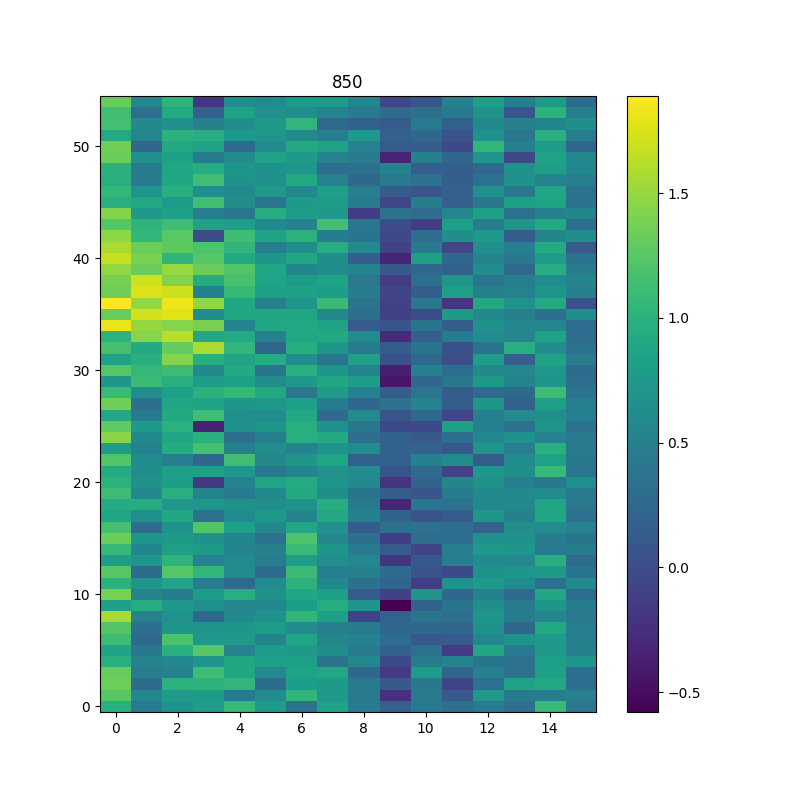

In [13]:
Make_Graph('850',df)

In [9]:
df

,Time,Position,PD1,PD2,PD3,PD4,PD5,PD6,PD7,PD8,PD9,PD10,PD11,PD12,PD13,PD14,PD15,PD16
1,2023-06-02 12:13:20.357835,26,0.009244,0.008370,0.009369,0.009216,0.008399,0.009728,0.007385,0.009507,0.009367,0.010003,0.008639,0.008812,0.009035,0.009342,0.008710,0.010198
2,2023-06-02 12:13:21.254893,52,0.009232,0.009719,0.008922,0.008087,0.008660,0.009398,0.008516,0.009899,0.009170,0.008835,0.009280,0.009661,0.008522,0.009962,0.008516,0.009669
3,2023-06-02 12:13:22.142279,78,0.008984,0.009748,0.008813,0.008634,0.008522,0.008959,0.008587,0.009595,0.009142,0.008026,0.010200,0.009360,0.008677,0.009551,0.008421,0.009796
4,2023-06-02 12:13:23.093757,104,0.009308,0.009423,0.009181,0.008187,0.009010,0.009498,0.008424,0.009594,0.009245,0.008388,0.010013,0.009160,0.009707,0.008141,0.009313,0.009732
5,2023-06-02 12:13:24.015106,130,0.009377,0.009263,0.008667,0.008577,0.009081,0.009047,0.008697,0.009940,0.009101,0.008335,0.009947,0.008879,0.008941,0.008890,0.008498,0.009636
6,2023-06-02 12:13:24.911033,156,0.009119,0.008946,0.009175,0.009625,0.008266,0.009015,0.008087,0.009569,0.009257,0.009194,0.009590,0.007630,0.009272,0.010027,0.008338,0.010083
7,2023-06-02 12:13:25.826178,182,0.009372,0.008629,0.009705,0.007540,0.009060,0.009538,0.009053,0.008490,0.009533,0.009129,0.009285,0.009615,0.008759,0.008950,0.008417,0.010014
8,2023-06-02 12:13:26.795019,208,0.008785,0.008912,0.009515,0.008325,0.009516,0.008307,0.008156,0.009645,0.009638,0.009106,0.008700,0.009232,0.008674,0.009811,0.009415,0.009871
9,2023-06-02 12:13:27.735842,234,0.009236,0.009145,0.009321,0.008828,0.007993,0.009167,0.009298,0.009651,0.009203,0.008675,0.009099,0.008818,0.009655,0.009439,0.008085,0.009408
10,2023-06-02 12:13:28.629334,260,0.009045,0.008748,0.009382,0.009429,0.008746,0.008521,0.008925,0.009313,0.009324,0.009820,0.009316,0.008087,0.008744,0.009843,0.008603,0.010445
